In [ ]:
# 2) Imports
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation

# %matplotlib inline  # Colab default is fine

In [ ]:

# 3) A Minimal "SimDrone" Class

class SimDrone:
    """
    A very simple drone simulator for teaching:
    - State: position (x, y, z), yaw (radians), time t.
    - Movement: steps toward a target with max horizontal & vertical speeds.
    - Mission: accepts a list of commands: TAKEOFF, GOTO, HOVER, LAND.
    - Logging: records (t, x, y, z, yaw) at each step.

    This is intentionally simple so beginners can read/modify it.
    """
    def __init__(self, pos=(0.0, 0.0, 0.0), yaw=0.0, max_speed=2.0, climb_speed=1.0, dt=0.05):
        self.pos = np.array(pos, dtype=float)       # [x, y, z]
        self.yaw = float(yaw)                        # radians
        self.max_speed = float(max_speed)            # m/s (horizontal)
        self.climb_speed = float(climb_speed)        # m/s (vertical)
        self.dt = float(dt)                          # simulation time step (s)
        self.t = 0.0
        self.log = []                                # list of dicts per step
        self._log()

    def _log(self):
        self.log.append({
            't': self.t,
            'x': self.pos[0],
            'y': self.pos[1],
            'z': self.pos[2],
            'yaw': self.yaw
        })

    def _step_to(self, target_pos):
        """
        Move one time step toward the target_pos respecting speed limits.
        Returns True when "close enough" to target.
        """
        target_pos = np.array(target_pos, dtype=float)
        diff = target_pos - self.pos

        # Horizontal (x,y) step limited by max_speed
        horizontal = diff.copy()
        horizontal[2] = 0.0
        dist_xy = np.linalg.norm(horizontal[:2])
        step = np.zeros(3, dtype=float)

        max_step_xy = self.max_speed * self.dt
        if dist_xy > 1e-9:
            step_xy = horizontal[:2] / dist_xy * min(max_step_xy, dist_xy)
            step[0:2] = step_xy

        # Vertical (z) step limited by climb_speed
        dz = diff[2]
        max_step_z = self.climb_speed * self.dt
        step[2] = np.clip(dz, -max_step_z, max_step_z)

        # Update yaw to face the direction of horizontal motion (if any)
        if np.linalg.norm(step[:2]) > 1e-9:
            self.yaw = math.atan2(step[1], step[0])

        # Apply movement and time
        self.pos += step
        self.t += self.dt
        self._log()

        # Close if within 5 cm of target in 3D
        return np.linalg.norm(target_pos - self.pos) < 0.05

    def run_mission(self, commands):
        """
        Run a sequence of commands. Each command is a tuple:
        - ('TAKEOFF', altitude_m)
        - ('GOTO', x, y, z)
        - ('HOVER', seconds)
        - ('LAND',)
        """
        for cmd in commands:
            name = cmd[0].upper()
            if name == 'TAKEOFF':
                altitude = float(cmd[1])
                # climb vertically to (current x, current y, altitude)
                target = np.array([self.pos[0], self.pos[1], altitude])
                while not self._step_to(target):
                    pass

            elif name == 'GOTO':
                _, x, y, z = cmd
                target = np.array([float(x), float(y), float(z)])
                while not self._step_to(target):
                    pass

            elif name == 'HOVER':
                seconds = float(cmd[1])
                end_time = self.t + seconds
                # "Hover" by stepping toward current position
                while self.t < end_time:
                    self._step_to(self.pos.copy())

            elif name == 'LAND':
                target = np.array([self.pos[0], self.pos[1], 0.0])
                while not self._step_to(target):
                    pass

            else:
                raise ValueError(f"Unknown command: {cmd}")


In [ ]:

# 4) Write a Basic Mission (TAKEOFF → SQUARE → LAND)

drone = SimDrone(max_speed=2.5, climb_speed=1.25, dt=0.05)

# Define a simple square at altitude z=5 m
mission = [
    ('TAKEOFF', 5),
    ('HOVER', 2),
    ('GOTO', 10, 0, 5),
    ('HOVER', 1),
    ('GOTO', 10, 10, 5),
    ('HOVER', 1),
    ('GOTO', 0, 10, 5),
    ('HOVER', 1),
    ('GOTO', 0, 0, 5),
    ('HOVER', 1),
    ('LAND',)
]

drone.run_mission(mission)
len(drone.log), f"Final position: ({drone.pos[0]:.2f}, {drone.pos[1]:.2f}, {drone.pos[2]:.2f}) m, time={drone.t:.1f}s"


(602, 'Final position: (0.00, 0.00, 0.00) m, time=30.1s')

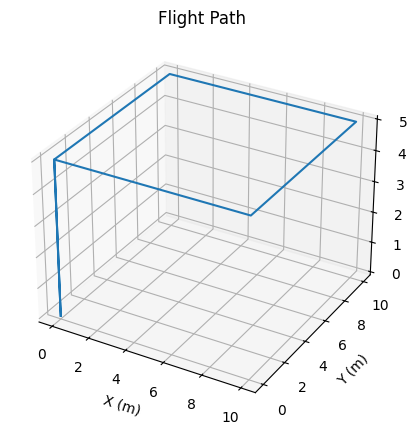

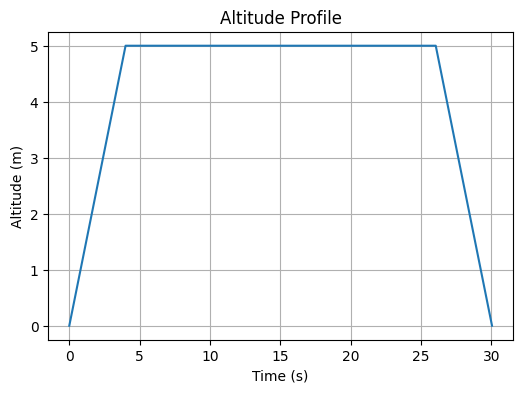

In [ ]:

# 5) Visualize the Flight Path (3D) and Altitude Profile

xs = [e['x'] for e in drone.log]
ys = [e['y'] for e in drone.log]
zs = [e['z'] for e in drone.log]
ts = [e['t'] for e in drone.log]

# 3D Path
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Flight Path')
plt.show()

# Altitude vs Time
fig = plt.figure(figsize=(6, 4))
plt.plot(ts, zs)
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Altitude Profile')
plt.grid(True)
plt.show()


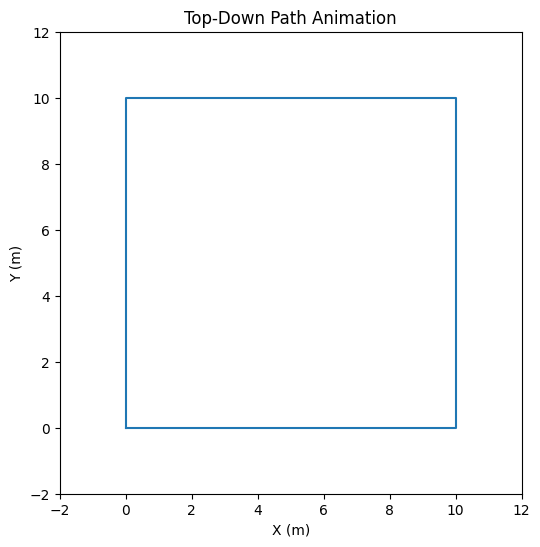

In [ ]:

# 6) (Optional) 2D Animation (Top-Down View)

fig = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Top-Down Path Animation')

ax.plot(xs, ys)  # full path
(drone_point,) = ax.plot([], [], marker='o', markersize=6)

ax.set_xlim(min(xs)-2, max(xs)+2)
ax.set_ylim(min(ys)-2, max(ys)+2)

def init():
    drone_point.set_data([], [])
    return (drone_point,)

def update(frame):
    drone_point.set_data(xs[frame], ys[frame])
    return (drone_point,)

ani = animation.FuncAnimation(fig, update, frames=len(xs), init_func=init, blit=True, interval=20)
plt.show()
